<a href="https://colab.research.google.com/github/crystaljwang/tm10007_group_3/blob/classifier/main_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General information
This machine learning model is developped to automatically distinguish gastrointestinal stromal tumours (GISTs) from from non-GISTs based on radiomics extracted from CT data.

Study: Technical Medicine Msc

Course: TM10007 Machine Learning

Date: 14th of April 2023




**Group 3**

4854659 - Geanne Bakker

5082676 - Julia van der Geest

5008018 - Crystal Wang

4652770 - Maurijn Wieringa

# All necessary libraries
All libraries used in this code are run here

In [86]:
# ----- Import necessary libraries -----

# General libraries
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Scipy libraries
from scipy.stats import shapiro 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV

#from sklearn.pipeline import make_pipeline
#from sklearn.pipeline import Pipeline

from sklearn import svm
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import metrics


# Imports

The code below loads the GIST data from GitHub. This was used once to create the test and train set. It is not needed to run this again

In [ ]:
# # Run this to use from colab environment
# !pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

# # Run this to use from colab environment
# !git clone https://github.com/jveenland/tm10007_ml.git

# %cd /content/tm10007_ml/worcgist

In [ ]:
# # ---- Import data -----
# dir = Path('.') / 'GIST_radiomicFeatures.csv'
# data = pd.read_csv(dir, index_col=0)

# print(f'The number of samples: {len(data.index)}')
# print(f'The number of columns: {len(data.columns)}')

# Splitting the data
This code was used to split the data the first time. To make sure we were all using the same train and test data we wrote csv files for the train and test data, that we are loading again below. This code is used once, and it is not necessary to run it again.

In [ ]:
# # Replace label values from string to binary
# data['label'] = data['label'].replace({'GIST': 1, 'non-GIST': 0})

# # Separate the features and labels
# X = data.drop(['label'], axis=1)
# y = data['label']

# # Split the data into random train and test sets
# X_train_tot, X_test, y_train_tot, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Write the X_test DataFrame to a CSV file
# X_train_tot.to_csv('X_train_tot.csv', index=False)
# X_test.to_csv('X_test.csv', index=False)
# y_train_tot.to_csv('y_train_tot.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)

# Load the train data

In [87]:
# Load split data from our repository
url = "https://raw.githubusercontent.com/crystaljwang/tm10007_group_3/main/data/"
X_train = pd.read_csv(url + 'X_train_tot.csv')
y_train = pd.read_csv(url + 'y_train_tot.csv')
X_test = pd.read_csv(url + 'X_test.csv')
y_test = pd.read_csv(url + 'y_test.csv')

# Split the data into train and validation sets
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

# Exploring the data

In [3]:
# Percentage GIST vs Non-GIST
counts = y_train.value_counts(normalize=True)
percentage_nongist = counts[0] * 100
percentage_gist = counts[1] * 100

print(f'Percentage of non-GIST in training set: {percentage_nongist:.2f}%')
print(f'Percentage of GIST in training set: {percentage_gist:.2f}%')

# Check for missing data
if X_train.isnull().sum().sum() > 0:
    print('Missing data found.')
    exit()
else:
    print('No missing data found.')

# Check for categorial values
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
if len(categorical_cols) > 0:
    print(f'Categorical columns found: {categorical_cols}')
    exit()
else:
    print('No categorical columns found.')

# Perform Shapiro-Wilk test for normality
p_values_above_threshold = []
for col in X_train.columns:
    stat, p = shapiro((X_train[col]))
    p_values_above_threshold.append(p > 0.05)

percent_above_threshold = sum(p_values_above_threshold) / len(p_values_above_threshold) * 100
print(f'{percent_above_threshold:.1f} percent of the data is normally distributed.')

Percentage of non-GIST in training set: 51.02%
Percentage of GIST in training set: 48.98%
No missing data found.
No categorical columns found.
12.2 percent of the data is normally distributed.


/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


# Preprocessing

In [88]:
# ----- Outliers -----

def replace_outliers(X_train, X_val, X_test):
    """
    Replaces the outliers in a DataFrame with the lower or upper bound.

    :param data: The DataFrame to be filtered
    :return: A new DataFrame with the outliers replaced by the lower or upper bound for each column
    """
    # Calculate the lower and upper bounds based on each column's median and interquartile range
    # based on train data
    Q1 = X_train.quantile(0.25)
    Q3 = X_train.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace the outliers with the lower or upper bound 
    # in train, validation and test data from train data fit
    for col in X_train.columns:
        X_train[col] = X_train[col].apply(lambda x: upper_bound[col] if x > upper_bound[col] else x)
        X_train[col] = X_train[col].apply(lambda x: lower_bound[col] if x < lower_bound[col] else x)
        X_val[col] = X_val[col].apply(lambda x: upper_bound[col] if x > upper_bound[col] else x)
        X_val[col] = X_val[col].apply(lambda x: lower_bound[col] if x < lower_bound[col] else x)        
        X_test[col] = X_test[col].apply(lambda x: upper_bound[col] if x > upper_bound[col] else x)
        X_test[col] = X_test[col].apply(lambda x: lower_bound[col] if x < lower_bound[col] else x)
  
    return X_train, X_val, X_test

# Replace the outliers in each column with the lower or upper bound
X_train, X_val, X_test = replace_outliers(X_train, X_val, X_test)

### Data Scaling

A MinMax scaler was used as most of the data is not normally distributed.

In [89]:
# ----- Data Scaling -----
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)  # fit scaler on train set
X_val = scaler.transform(X_val)  # apply fitted scaler on validation set
X_test = scaler.transform(X_test)  # apply fitted scaler on test set

### Remove zero-variance features

In [90]:
# ----- Remove zero-variance features -----
X_train = pd.DataFrame(X_train)
zero_var_filter = VarianceThreshold(threshold=0)

# Fit on train data
zero_var_filter.fit(X_train)
# zero_var_columns = [column for column in X_train.columns if column not in X_train.columns[zero_var_filter.get_support()]] # Print this variable to visualize which features have zero-variance

# Apply on train, validation and test data
X_train = zero_var_filter.transform(X_train)
X_val = zero_var_filter.transform(X_val)
X_test = zero_var_filter.transform(X_test)

### Feature extraction

In [91]:
# ----- Feature extraction -----

# 95% variance
pca = PCA(n_components = 0.95)
pca.fit(X_train) #fit PCA on train set

#Apply fitted PCA feature extraction on train, validation and test set
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

print(f"Selected {X_train.shape[1]} features to be used for classification.")

Selected 60 features to be used for classification.


### Feature selection

In [92]:
# ----- Feature selection -----
lasso_selector = SelectFromModel(estimator=Lasso(alpha=0.015, max_iter=1000), threshold=None)
lasso_selector.fit(X_train, y_train)
lasso_list = [column for column in pd.DataFrame(X_train).columns[lasso_selector.get_support()]]
n_original = X_train.shape[1]

#Apply fitted feature selection on train, validation and test set
X_train = lasso_selector.transform(X_train)
X_val = lasso_selector.transform(X_val)
X_test = lasso_selector.transform(X_test)

#Print selected featues
n_selected = X_train.shape[1]
print(f"Selected {n_selected} from {n_original} features.")

Selected 22 from 60 features.


# Classifier
Now the features are selected, we are testing the different classifiers.

In [93]:
def learning_curve(X_train, y_train, search, model_name):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 6))

  model = search.best_estimator_  # get the best estimator from the RandomizedSearchCV object
  model.set_params(**search.best_params_)  # set the best hyperparameters on the model
  

  common_params = {
      "X": X_train,
      "y": y_train,
      "train_sizes": np.linspace(0.1, 1.0, 5),
      "cv": ShuffleSplit(n_splits=5, test_size=0.15, random_state=0),
      "score_type": "both",
      "n_jobs": 4,
      "line_kw": {"marker": "o"},
      "std_display_style": "fill_between",
      "score_name": "Accuracy",
  }

  LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)
  handles, label = ax.get_legend_handles_labels()
  ax.legend(handles[:2], ["Training Score", "Test Score"])
  ax.set_title(f"Learning Curve for {model_name.__class__.__name__}")
  plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 30 is smaller than n_iter=500. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Score: 0.7855263157894737
Best Hyperparameters: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 3}


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


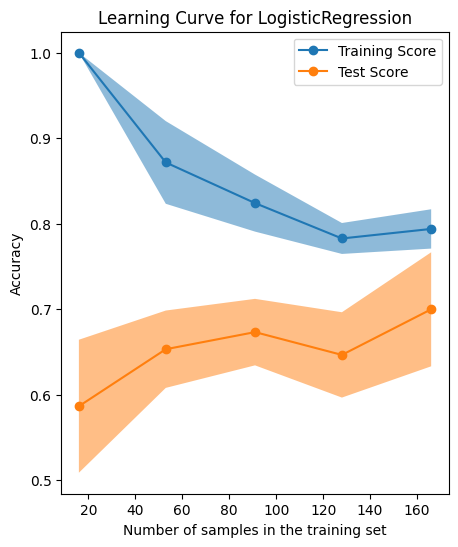

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 60 is smaller than n_iter=500. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Score: 0.7895263157894737
Best Hyperparameters: {'kernel': 'linear', 'gamma': 1, 'C': 10}


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


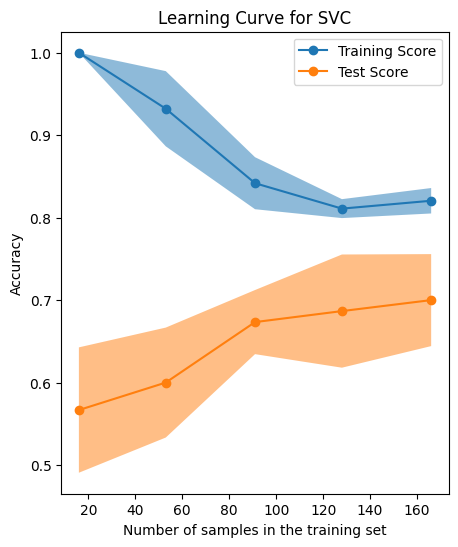

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 54 is smaller than n_iter=500. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Score: 0.675342105263158
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'}


/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


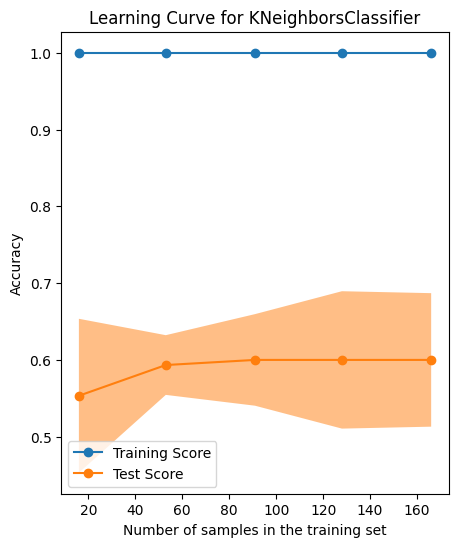

                 Model  Accuracy   AUC  Precision    Recall  Specificity
0  Logistic Regression      0.54  0.56   0.650000  0.448276     0.666667
1                  SVC      0.58  0.59   0.681818  0.517241     0.666667
2                  KNN      0.64  0.66   0.761905  0.551724     0.761905


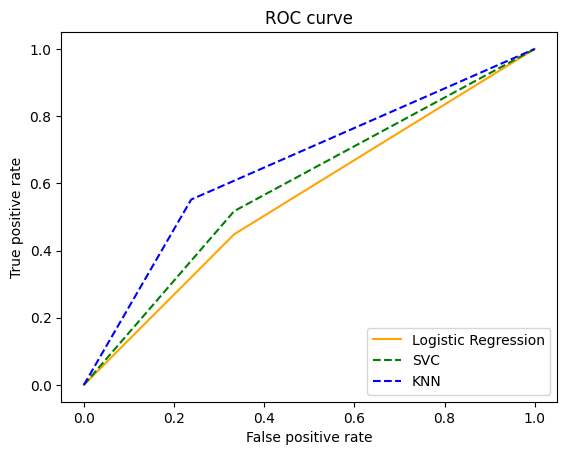

In [95]:
# VALIDATION
model_pipeline = [LogisticRegression(), SVC(), KNeighborsClassifier()]


# Grid lists
param_grid_LR = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], 
                  'penalty': ['l2'],
                  'C': list(range(1,10,2))}
param_grid_SVC = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'poly', 'rbf']} 
param_grid_KNN = {'n_neighbors': list(range(1,10,1)), 
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan', 'minkowski']}              

# Prepare lists for pipeline
model_list = ['Logistic Regression', 'SVC', 'KNN']
grid_list = [param_grid_LR, param_grid_SVC, param_grid_KNN]
acc_list = []
auc_list = []
cm_list = []
fpr_list = []
tpr_list = []
prec_list = []
recall_list = []
spec_list = []

# Execute pipeline
for model, grid in zip(model_pipeline, grid_list):
    search = RandomizedSearchCV(
        model, grid,
        n_iter=500, scoring="roc_auc", n_jobs=-1, cv=5, random_state=1)
  
    search.fit(X_train, y_train)  # train model

    print('Best Score: %s' % search.best_score_)
    print('Best Hyperparameters: %s' % search.best_params_)

    y_pred = search.predict(X_test)  # use trained model to predict values of y
    acc_list.append(metrics.accuracy_score(y_test, y_pred))  # calculate accuracy on prediction of y
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred)
    prec_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(round(metrics.auc(fpr, tpr),2))  # calculate area under the curve on prediction of y
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    specificity = TN / (TN + FP)
    spec_list.append(specificity)
    cm_list.append(cm)
    learning_curve(X_train, y_train, search, model)  #make a learning curve with function learning curve. NB: this is a different model than the model trained above

result_df = pd.DataFrame({'Model':model_list, 'Accuracy': acc_list, 'AUC': auc_list, 'Precision': prec_list, 'Recall': recall_list, 'Specificity': spec_list})
print(result_df)


    # Create ROC curve
    
#plt.plot(fpr,tpr)
plt.plot(fpr_list[0],tpr_list[0],linestyle='-',color='orange',label=model_list[0])
plt.plot(fpr_list[1],tpr_list[1],linestyle='--',color='green',label=model_list[1])
plt.plot(fpr_list[2],tpr_list[2],linestyle='--',color='blue',label=model_list[2])
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

In [ ]:
# ----- TEST SET ------

# Prepare pipeline
acc_list = []
auc_list = []
cm_list = []

# Execute pipeline
for model in fit_model:
    y_pred = model.predict(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred)
    auc_list.append(round(metrics.auc(fpr, tpr),2))
    cm_list.append(confusion_matrix(y_test, y_pred))
    # Create ROC curve
    
    # plt.plot(fpr,tpr)
    # # plt.plot(fpr,tpr,label='AUC='+str(metrics.roc_auc_score(y_test, y_pred)))
    # plt.ylabel('True positive rate')
    # plt.xlabel('False positive rate')
    # plt.legend(loc=4)
    # plt.show()

print(acc_list)
print(model_list)
print(auc_list)

##VALIDATION
# Plot Model validation
result_df = pd.DataFrame({'Model':model_list, 'Accuracy': acc_list, 'AUC': auc_list})
result_df

NameError: ignored

In [ ]:


#validate
y_pred = search.predict(X_val)
acc = (metrics.accuracy_score(y_val, y_pred))
fpr, tpr, _thresholds = metrics.roc_curve(y_val, y_pred)
auc = (round(metrics.auc(fpr, tpr),2))

print(auc)
print(acc)

1.0
1.0


In [ ]:
# ----- Classifiers -----

# Prepare pipeline
model_pipeline = [LogisticRegression(max_iter=1000), SVC(), LinearSVC(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB()]

model_list = ['LogisticRegression', 'SVC', 'Linear SVC', 'KNN', 'Decision Tree', 'Random Forest', 'Naive Bayes']

# Execute pipeline
for model in model_pipeline:
    learningcurve(X_train, y_train, model)

NameError: ignored

In [ ]:
# Nieuw stuk code learning curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve

y_train = pd.DataFrame(y_train)
y_train = y_train.to_numpy()

# for model in model_pipeline:
#     print(f"{model} was used as a classifier")
#     train_size_abs, train_scores, test_scores = learning_curve(LinearSVC(), X_train, y_train.ravel())
#     auc_train_size_abs, auc_train_scores, auc_test_scores = learning_curve(LinearSVC(), X_train, y_train.ravel(), scoring='roc_auc')
# # train_size_abs, train_scores, test_scores = learning_curve(LinearSVC(), X_train.to_numpy, y_train)
#     # train_size_abs, train_scores, test_scores = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=ShuffleSplit(n_splits=5, test_size=0.15, random_state=0))
#     # auc_train_size, auc_train_scores, auc_test_scores = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=ShuffleSplit(n_splits=5, test_size=0.15, random_state=0), scoring='roc_auc')

#     for train_size, cv_train_scores, cv_test_scores in zip(train_size_abs, train_scores, test_scores):
#         print(f"{train_size} samples were used to train the model")
#         print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
#         print(f"The average test accuracy is {cv_test_scores.mean():.2f}")

#     for a, b, c in zip(auc_train_size_abs, auc_train_scores, auc_test_scores):
#         print(f"{a} samples were used to train the model")
#         print(f"The average train AUC is {b.mean():.2f}")
#         print(f"The average test AUC is {c.mean():.2f}")